# Inception V3
#### tensorflow==2.18.0

In [21]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
from tensorflow import keras
from keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, BatchNormalization, Dropout

In [22]:
train_dir = r"/content/PLANT_VILLAGE_SPLIT/train"
test_dir = r"/content/PLANT_VILLAGE_SPLIT/test"
val_dir = r"/content/PLANT_VILLAGE_SPLIT/val"

In [ ]:
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 16

In [ ]:
def preprocess_function(image):
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    return image

In [26]:
datagen = ImageDataGenerator(rescale=1.0/255,
                             preprocessing_function=preprocess_function)

In [27]:
train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_generator = datagen.flow_from_directory(
    val_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_generator = datagen.flow_from_directory(
    test_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

Found 32572 images belonging to 38 classes.
Found 10849 images belonging to 38 classes.
Found 10885 images belonging to 38 classes.


In [28]:
from tensorflow.keras.applications import InceptionV3

In [32]:
base_model = InceptionV3(weights='imagenet' ,include_top=False , input_shape=(224,224,3), pooling='max' )

model = Sequential()
model.add(base_model)

model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(38, activation='softmax'))

for layer in base_model.layers:
    layer.trainable = False

In [ ]:
model.compile(tf.keras.optimizers.Adam(learning_rate = 0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [34]:
model.build(input_shape=(None, 224, 224, 3))
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ inception_v3 (Functional)            │ (None, 2048)                │      21,802,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_285              │ (None, 2048)                │           8,192 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_286              │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_287              │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 38)                  │           4,902 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 22,095,686 (84.29 MB)

 Trainable params: 288,294 (1.10 MB)

 Non-trainable params: 21,807,392 (83.19 MB)

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.005, patience=5, restore_best_weights=True)

In [36]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,
    callbacks=[early_stopping]
)

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2036/2036 ━━━━━━━━━━━━━━━━━━━━ 216s 95ms/step - accuracy: 0.6349 - loss: 1.3199 - val_accuracy: 0.8782 - val_loss: 0.3697
Epoch 2/50
2036/2036 ━━━━━━━━━━━━━━━━━━━━ 175s 86ms/step - accuracy: 0.8448 - loss: 0.4944 - val_accuracy: 0.8946 - val_loss: 0.3101
Epoch 3/50
2036/2036 ━━━━━━━━━━━━━━━━━━━━ 175s 86ms/step - accuracy: 0.8692 - loss: 0.3937 - val_accuracy: 0.9042 - val_loss: 0.2914
Epoch 4/50
2036/2036 ━━━━━━━━━━━━━━━━━━━━ 179s 88ms/step - accuracy: 0.8886 - loss: 0.3350 - val_accuracy: 0.9108 - val_loss: 0.2751
Epoch 5/50
2036/2036 ━━━━━━━━━━━━━━━━━━━━ 213s 105ms/step - accuracy: 0.9050 - loss: 0.2893 - val_accuracy: 0.9124 - val_loss: 0.2677
Epoch 6/50
2036/2036 ━━━━━━━━━━━━━━━━━━━━ 175s 86ms/step - accuracy: 0.9088 - loss: 0.2709 - val_accuracy: 0.9092 - val_loss: 0.2700
Epoch 7/50
2036/2036 ━━━━━━━━━━━━━━━━━━━━ 200s 85ms/step - accuracy: 0.9162 - loss: 0.2482 - val_accuracy: 0.9117 - val_loss: 0.2669
Epoch 8/50
2036/2036 ━━━━━━━━━━━━━━━━━━━━ 174s 85ms/step - accuracy: 0.9294 - l

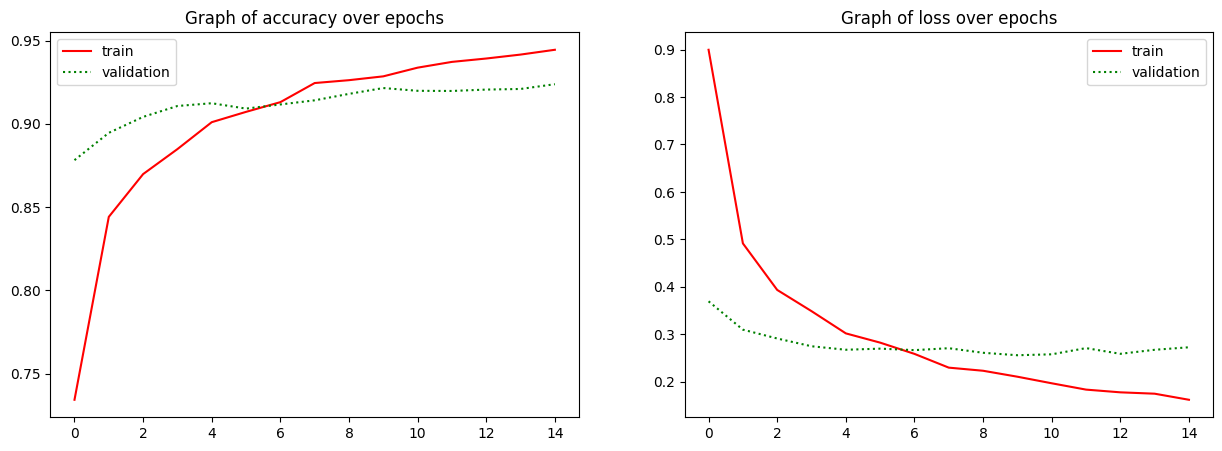

In [38]:
def printplot(history):
        plt.figure(figsize=(15, 5))
        plt.subplot(1, 2, 1)
        plt.plot(history.history["accuracy"], color="red", label="train")
        plt.plot(history.history["val_accuracy"], color="green", label="validation", linestyle="dashed")
        plt.title("Graph of accuracy over epochs")
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(history.history["loss"], color="red", label="train")
        plt.plot(history.history["val_loss"], color="green", label="validation", linestyle="dashed")
        plt.title("Graph of loss over epochs")
        plt.legend()

printplot(history)

In [37]:
model.save("INCEPTION.h5")

In [ ]:
test_loss, test_accuracy = model.evaluate(test_generator)

print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


681/681 ━━━━━━━━━━━━━━━━━━━━ 48s 71ms/step - accuracy: 0.9215 - loss: 0.2659
Test Accuracy: 92.16%
Test Loss: 0.2679
